<a href="https://colab.research.google.com/github/seljmov/breakdown-prediction-model/blob/main/train_test_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Список праздничных дней
holidays = [
    (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (8, 1), # Новогодние каникулы
    (7, 1), # Рождество Христово
    (23, 2), # День защитника Отечества
    (8, 3), # Международный женский день
    (1, 5), # Праздник Весны и Труда
    (9, 5), # День Победы
    (12, 6), # День России
    (4, 11) # День народного единства
]

# Функция для проверки, является ли день праздником
def is_holiday(date):
    return (date.day, date.month) in holidays

# Сроки школьных каникул
def is_school_holiday(date):
    # Осенние каникулы
    if date >= pd.Timestamp(date.year, 10, 28) and date <= pd.Timestamp(date.year, 11, 6):
        return True
    # Зимние каникулы
    if date >= pd.Timestamp(date.year, 12, 28) and date <= pd.Timestamp(date.year, 1, 8):
        return True
    # Весенние каникулы
    if date >= pd.Timestamp(date.year, 3, 24) and date <= pd.Timestamp(date.year, 4, 2):
        return True
    # Летние каникулы
    if date >= pd.Timestamp(date.year, 6, 1) and date <= pd.Timestamp(date.year, 8, 31):
        return True
    return False

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# Чистые данные
data_file_1 = '/content/output_full.csv'

# Чистые данные с весами
data_file_2 = '/content/output_with_weight.csv'

# Чистые данные с весами и доп весами для предыдущих поломок
data_file_3 = '/content/output_with_weight_n3.csv'

data_file_4 = '/content/output_with_weight_n2.csv'

data_file_5 = '/content/output_with_weight_n2_2.csv'

breakdowns_file = '/content/future_breakdowns.csv'

# Загрузка данных
data = pd.read_csv(data_file_5)

# Подготовка данных для модели SARIMAX
# Все колонки address,date,day,month,year,day_of_week,season,holiday,school_holiday,count,breakdown,weight
y = data['breakdown']
X = data[['day', 'month', 'year', 'day_of_week', 'holiday', 'school_holiday', 'weight']]
#X = data[['day', 'month', 'year', 'day_of_week', 'holiday', 'school_holiday', 'weight']]

# Создание коллекции весов, привязанных к дню и месяцу
weight_by_day_month = data.groupby(['day', 'month'])['weight'].sum().to_dict()

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(data) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# Обучение модели SARIMAX
model = SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 92), exog=X_train)
model_fit = model.fit(disp=False)

# Прогнозирование на тестовых данных
y_pred = model_fit.predict(start=train_size, end=len(data)-1, exog=X_test)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


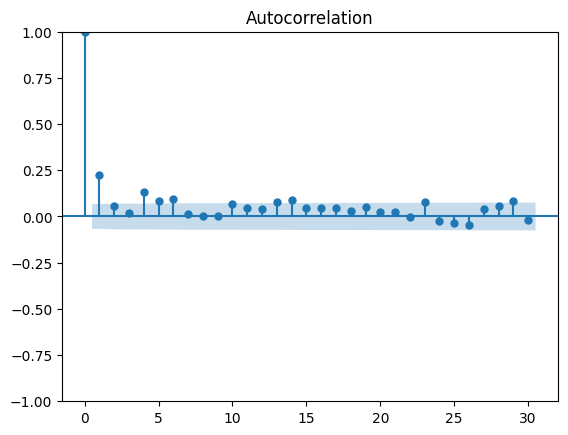

In [ ]:
# Фильтрация данных, где breakdown = 1
filtered_data = data

# Преобразование в формат временного ряда (предполагая, что у вас есть столбец с датами)
filtered_data['date'] = pd.to_datetime(filtered_data[['year', 'month', 'day']])
filtered_data.set_index('date', inplace=True)

# Построение автокорреляционной функции
plot_acf(filtered_data['breakdown'])
plt.show()

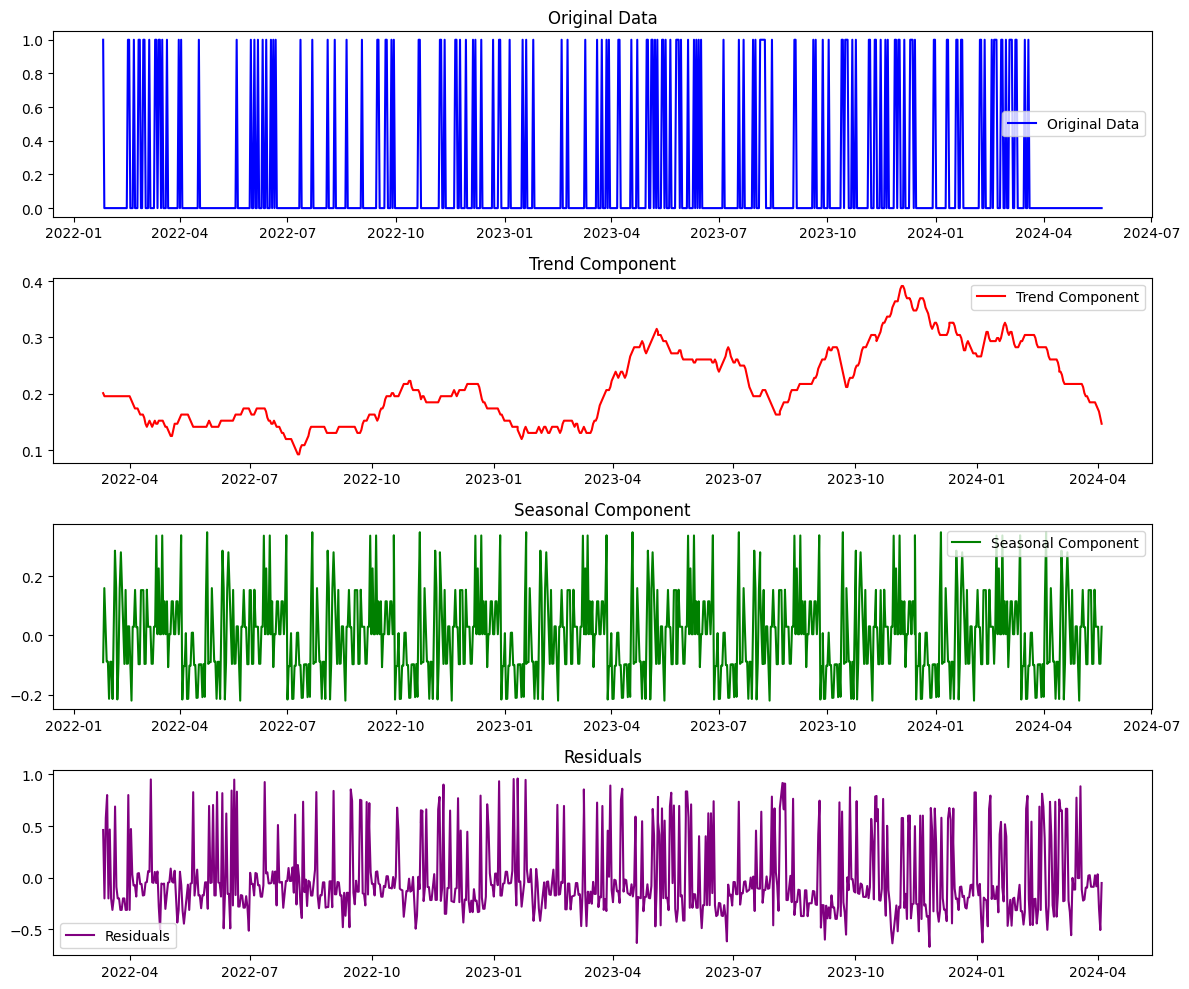

In [ ]:
# Фильтрация данных, где breakdown = 1
filtered_data = data

# Определение отклика и признаков
filtered_y = filtered_data['breakdown']
filtered_X = filtered_data[['day', 'month', 'year', 'day_of_week', 'holiday', 'school_holiday', 'weight']]

# Разложение временного ряда
result = seasonal_decompose(filtered_y, model='additive', period=92)

# Извлечение компонентов
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Построение графиков
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(filtered_y, label='Original Data', color='blue')
plt.title('Original Data')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend Component', color='red')
plt.title('Trend Component')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal Component', color='green')
plt.title('Seasonal Component')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='purple')
plt.title('Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

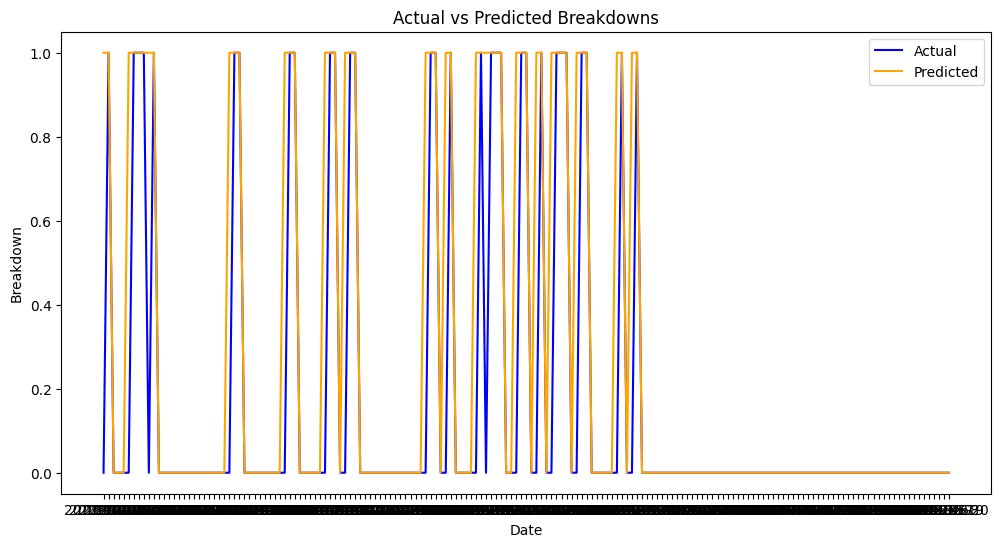

In [ ]:
y_pred_custom = (y_pred > 0.4).astype(int)

# Визуализация тестовой выборки и прогноза
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_size:], y_test, label='Actual', color='blue')
plt.plot(data['date'][train_size:], y_pred_custom, label='Predicted', color='orange')
plt.title('Actual vs Predicted Breakdowns')
plt.xlabel('Date')
plt.ylabel('Breakdown')
plt.legend()
plt.show()

In [ ]:
# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 0.12643782022690825
RMSE: 0.2318440956843963
R^2: 0.6710341039066172


### Результаты с учетом колонок: ['day', 'month', 'year', 'day_of_week', 'weight']

1. output_full results (без учета weight):
```
MAE: 0.3952785761918539
RMSE: 0.48918137104435383
R^2: -0.08017661495696493
```

2. output_with_weight results:
```
MAE: 0.0741133140102829
RMSE: 0.13702541002890672
R^2: 0.9152465917810579
```

3. output_with_weight_n3 results:
```
MAE: 0.18333282524523709
RMSE: 0.2860957322062848
R^2: 0.6305312513358291
```

In [ ]:
# Преобразование строки даты в формат datetime
data['date'] = pd.to_datetime(data['date'])

# Определение начальной даты для будущих прогнозов
period = 100
start_date_future = data['date'].max() + pd.Timedelta(days=3)
final_date_future = start_date_future + pd.Timedelta(days=period)

print("Начало для будущих прогнозов:", start_date_future.date())
print("Конец для будущих прогнозов:", final_date_future.date())

# Создание списка будущих дат
future_dates = pd.date_range(start=start_date_future, periods=period)
future_df = pd.DataFrame(future_dates, columns=['date'])
future_df['day'] = future_df['date'].dt.day
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year
future_df['day_of_week'] = future_df['date'].dt.dayofweek
future_df['holiday'] = future_df['date'].apply(lambda x: 1 if is_holiday(x) else 0)
future_df['school_holiday'] = future_df['date'].apply(lambda x: 0.5 if is_school_holiday(x) else 0)

# Присвоение весов на основе коллекции весов, привязанных к дню и месяцу
future_df['weight'] = future_df.apply(lambda row: weight_by_day_month.get((row['day'], row['month']), 0), axis=1)

# Прогнозирование на будущее
future_exog = future_df[['day', 'month', 'year', 'day_of_week', 'holiday', 'school_holiday', 'weight']]
#future_exog = future_df[['day', 'month', 'year', 'day_of_week', 'holiday', 'school_holiday', 'weight']]
# теория надежности и тп
# обратиться к текущим, сказать, что в них не так и как исправить
# нужна концептуальная постановка задачи
# есть такое, работает так-то, использовалось то-то, плохо, потому что, а мы хотим использовать то-то
# если временной ряд, то как меняется наша переменная

# нужно составить нормальный план изложения. наработки на отказ.
# почему беру временные ряды и что я моделирую.

#предметка,
#концептуальная постановка,
#какие приняли допущения,
#какой апарат математический используем (развиваем используемый или предлагаем свой),
#что хотим получить (модель чего или комплекс моделей)

Начало для будущих прогнозов: 2024-05-23
Конец для будущих прогнозов: 2024-08-31


In [ ]:
# Получение прогнозов на будущее
future_predictions = model_fit.get_forecast(steps=period, exog=future_exog)

# Получение среднего значения прогноза
predicted_mean = future_predictions.predicted_mean

# Вывод прогноза
future_df['breakdown_prediction'] = predicted_mean.values

# Нормализация значений в столбце 'breakdown_prediction'
scaler = MinMaxScaler()
#future_df['breakdown_prediction'] = scaler.fit_transform(future_df[['breakdown_prediction']])
future_df['breakdown'] = (future_df['breakdown_prediction'] > 0.49).astype(int)

# Проверка последовательных дней с breakdown == 1
for i in range(1, len(future_df)):
    if future_df.loc[i, 'breakdown'] == 1 and future_df.loc[i - 1, 'breakdown'] == 1:
        if future_df.loc[i, 'breakdown_prediction'] > future_df.loc[i - 1, 'breakdown_prediction']:
            future_df.loc[i - 1, 'breakdown'] = 0
        else:
            future_df.loc[i, 'breakdown'] = 0

# Сохранение прогноза в файл
futured_breakdowns = future_df[['date', 'breakdown_prediction', 'breakdown']]
futured_breakdowns = futured_breakdowns[futured_breakdowns['breakdown'] == 1]
futured_breakdowns.to_csv(breakdowns_file, index=False)

In [ ]:
print(futured_breakdowns)

         date  breakdown_prediction  breakdown
4  2024-05-27              1.698868          1
8  2024-05-31              1.717666          1
13 2024-06-05              0.848390          1
18 2024-06-10              0.868787          1
21 2024-06-13              0.841402          1
25 2024-06-17              2.135604          1
43 2024-07-05              0.841024          1
60 2024-07-22              1.296548          1
74 2024-08-05              2.556526          1
77 2024-08-08              2.535342          1
79 2024-08-10              0.834847          1


1. Прогнозирование с модели output_with_weight
```
         date  breakdown_prediction  breakdown
0  2024-03-20              0.850124          1
1  2024-03-21              0.849419          1
2  2024-03-22              0.008766          0
3  2024-03-23              0.004034          0
4  2024-03-24              1.671549          1
5  2024-03-25              0.019464          0
6  2024-03-26              0.021483          0
7  2024-03-27              0.017287          0
8  2024-03-28              0.849547          1
9  2024-03-29              0.010976          0
10 2024-03-30              0.842682          1
11 2024-03-31              0.839290          1
12 2024-04-01              0.027518          0
13 2024-04-02              0.859243          1
14 2024-04-03              0.021336          0
15 2024-04-04              0.018092          0
16 2024-04-05              0.014876          0
17 2024-04-06              0.011626          0
18 2024-04-07              0.843130          1
19 2024-04-08              0.861615          1
20 2024-04-09              0.023712          0
21 2024-04-10              0.020476          0
22 2024-04-11              0.017258          0
23 2024-04-12              0.014027          0
24 2024-04-13              0.010804          0
25 2024-04-14              0.007576          0
26 2024-04-15              0.026078          0
27 2024-04-16              0.022852          0
28 2024-04-17              0.854339          1
29 2024-04-18              0.851113          1
30 2024-04-19              0.013176          0
31 2024-04-20              0.009950          0
32 2024-04-21              0.006725          0
33 2024-04-22              0.025225          0
34 2024-04-23              0.856711          1
35 2024-04-24              0.018774          0
36 2024-04-25              0.015548          0
37 2024-04-26              0.012323          0
38 2024-04-27              0.009097          0
39 2024-04-28              0.005871          0
40 2024-04-29              0.024371          0
41 2024-04-30              0.021145          0
42 2024-05-01              0.856835          1
43 2024-05-02              0.853609          1
44 2024-05-03              0.015672          0
45 2024-05-04              0.012446          0
46 2024-05-05              1.678644          1
47 2024-05-06              0.862432          1
48 2024-05-07              0.024495          0
49 2024-05-08              0.855981          1
```

2. Прогнозирование с модели output_with_weight_n3
```
  date  breakdown_prediction  breakdown
0  2024-03-20              0.718342          1
1  2024-03-21              0.452683          0
2  2024-03-22              0.042197          0
3  2024-03-23              0.797677          1
4  2024-03-24              0.907380          1
5  2024-03-25              0.002765          0
6  2024-03-26              0.048148          0
7  2024-03-27              0.425910          0
8  2024-03-28              0.501168          0
9  2024-03-29              0.434538          0
10 2024-03-30              0.863383          1
11 2024-03-31              0.478076          0
12 2024-04-01              0.428995          0
13 2024-04-02              0.479953          0
14 2024-04-03              0.007473          0
15 2024-04-04              0.000325          0
16 2024-04-05              0.022221          0
17 2024-04-06              0.422341          0
18 2024-04-07              0.851502          1
19 2024-04-08              0.488490          0
20 2024-04-09              0.016004          0
21 2024-04-10              0.008861          0
22 2024-04-11              0.001719          0
23 2024-04-12             -0.005424          0
24 2024-04-13             -0.012566          0
25 2024-04-14             -0.019709          0
26 2024-04-15              0.053582          0
27 2024-04-16              0.453702          0
28 2024-04-17              0.882863          1
29 2024-04-18              0.468458          0
30 2024-04-19             -0.004028          0
31 2024-04-20             -0.011171          0
32 2024-04-21              0.010727          0
33 2024-04-22              0.433200          0
34 2024-04-23              0.484139          0
35 2024-04-24              0.011653          0
36 2024-04-25              0.004510          0
37 2024-04-26             -0.002632          0
38 2024-04-27             -0.009775          0
39 2024-04-28             -0.016918          0
40 2024-04-29              0.056374          0
41 2024-04-30              0.456494          0
42 2024-05-01              0.879822          1
43 2024-05-02              0.465417          0
44 2024-05-03              0.021971          0
45 2024-05-04              0.422092          0
46 2024-05-05              1.752899          1
47 2024-05-06              0.517420          0
48 2024-05-07              0.423017          0
49 2024-05-08              0.532176          0
```